In [1]:
#THIS IS THE MAIN FILE FOR TRAINING
#TODO SAN landmarks
#TODO: first few iterations of spectrogram and last few iterations of mel spectrogram


#Step1 
# reading video data
import random
random.seed(5)
import numpy as np
np.random.seed(5)
import os
os.environ['PYTHONHASHSEED']=str(5)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
import tensorflow as tf
tf.random.set_seed(5)

import scipy.io as scio
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D,Conv3D, MaxPooling3D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Input, LayerNormalization
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import optimizers

from keras.utils import to_categorical
from IPython.display import clear_output
from librosa.effects import preemphasis
from librosa.core import piptrack
#import tensorflow_probability as tfp
batch_size=32

Using TensorFlow backend.


In [2]:
#read videos and audio as training data for my own video encoder. If using vgg net check next cell
#step2
from os import listdir
from os.path import isfile, join, getmtime
from scipy.io import wavfile
from sklearn import preprocessing
from librosa import feature, effects
from scipy.signal import savgol_filter
#to play audio
from IPython.display import Audio 


import parselmouth
from parselmouth.praat import call

freq=25

#parameters than need to be tuned
shp=16384 #length of audio from each video. This is the minimum.- 9600
frameWidth=2
frameHeight=29 #68
frameCount=80 #50 before or 80
maxCount=1;

###############################
#pad video with 0 or interpolation
pad_video=False # false = interpolation
#stretch or pad audio with 0s
pad_audio=0 # 0 = stretch
#optflow or SAN or aligned face
opt=2 # 3: aligned+landmark 2: aligned+optflow, 1: optflow, 0: landmarks
mel_w=0 #weight on the mel term in spec loss
data_augment=False
normalize_video=False # make landmarks -1 to 1
include_style=False

region=2 # 0: jaw,  1: mouth only, 2: both for landmark indices
##########################

Xtrain=[]
Xtrain_aud=[]

Xtrain_aug=[]


newstyles=np.load('styles_1100.mat.npy')
newstyles=newstyles-1 #change the range from 1-2 to 0-1

filelist=np.load('filelist_1100.mat.npy')
print(np.shape(filelist)[0])
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_std= preprocessing.StandardScaler()
scaler_max= preprocessing.MaxAbsScaler()
for i in range(np.shape(filelist)[0]):
    if (opt==1):
        vfile=filelist[i]+'_optflow.npy'
    elif (opt==2):
        vfile=filelist[i]+'_aligned.npy'
    elif (opt==3):
        vfile=filelist[i]+'_aligned_landmarks2.npy'
    else:
        vfile=filelist[i]+'_landmarks.npy'
    afile=filelist[i]+'_audio.wav'
    
    #_both.wmv contains both audio and video
    print(vfile)
    sr,aud = wavfile.read(afile)
    #image is of shape timepts x landmark pts x 1 x coordinates e.g. (28, 68, 2)
    image1=np.load(vfile)

    image=[]
    image_aug=[]
    for tp in range(np.shape(image1)[0]):
        #tp x landmarks x coordinates
        # measurements based on nose center point 33
        #normalize based on distance between the eyes and eye: 45 and 39
        #normalize basedon distance between eye and nose: 33 and 27
        if region==2:
            landmarks_indices=[*range(4,13),*range(48,68)] #5:13 is lower jaw and 49:68 is lips
        elif region ==1:
            landmarks_indices=[*range(48,68)] #mouth only
        elif region ==0:
            landmarks_indices=[*range(4,13)] #jaw only
        
        #for x-axis
        tempX = np.float32(image1[tp,landmarks_indices,0] - image1[tp,33,0])/(image1[1,45,0] - image1[1,39,0])
        
        augX=  np.float32(image1[tp,33,0] - image1[tp,landmarks_indices,0])/(image1[1,45,0] - image1[1,39,0])
        #for y-axis
        tempY = np.float32(image1[tp,landmarks_indices,1] - image1[tp,33,1])/(image1[1,33,1] - image1[1,27,1])
        if(tp==0):
            firstX=tempX
            firstY=tempY
            augfirstX=augX

        image.append(np.concatenate((tempX-firstX,tempY-firstY), axis=0))
        if data_augment:
            image_aug.append(np.concatenate((augX-augfirstX,tempY-firstY), axis=0))
    

    #because cv has width x height and numpy is heightxwidth
    dim = (np.shape(landmarks_indices)[0]*2,frameCount)
    # resize image
    if pad_video:
        if 0:
            offset= np.int(np.round((frameCount-np.shape(image)[0])/2))
            hsv=np.zeros((frameCount,frameHeight*frameWidth));
            hsv[offset:offset+np.shape(image)[0],:]=image
        else:
            
            hsv=np.pad(image,((0, frameCount-np.shape(image)[0]),(0,0)), mode='edge')
            if data_augment:
                hsv_aug=np.pad(image_aug,((0, frameCount-np.shape(image)[0]),(0,0)), mode='edge')
            #print(np.shape(image),np.shape(hsv))
        
    else:
        #(56, 58) (64, 58)
        hsv = cv2.resize(np.float32(image), dim, interpolation = cv2.INTER_CUBIC)
        if data_augment:
            hsv_aug = cv2.resize(np.float32(image_aug), dim, interpolation = cv2.INTER_CUBIC)
            
        
    #plt.subplot(2,1,1)
    #plt.plot(hsv)
    for lp in range(np.shape(hsv)[1]):
        #smooth the video data: TODO - play with window size
        yhat = savgol_filter(hsv[:,lp], 5, 4) # window size 35, polynomial order 3
        hsv[:,lp] = yhat
    
    if data_augment:
        for lp in range(np.shape(hsv_aug)[1]):
            #smooth the video data: TODO - play with window size
            yhat = savgol_filter(hsv_aug[:,lp], 5, 4) # window size 35, polynomial order 3
            hsv_aug[:,lp] = yhat

        Xtrain_aug.append(hsv_aug) 
    #plt.subplot(2,1,2)
    #plt.plot(hsv)

        
    print(np.shape(image), np.shape(hsv), sr)
    # append the next video file
    if normalize_video:
        test=scaler_std.fit_transform(hsv)
        Xtrain.append(test)
    else:
        Xtrain.append(hsv)#np.nan_to_num(buf)
    #convert stereo to mono
    #aud=aud[1] # use this if you do not need sampling rate
    #adjust the size of audio
    
    #remove silence from the audio
    aud, index=effects.trim(np.float32(aud), top_db=freq)
    #duration can act as another feature
    duration = np.shape(aud)[0]
    #hack to get the sizes correct
    aud=np.append(aud,np.zeros([1024]))
    if (pad_audio==1):
        if(shp > np.shape(aud)[0]):
            aud = np.pad(np.float32(aud), (0, shp-np.shape(aud)[0]), 'constant', constant_values=(0, 0))
        else:
            aud = aud[0:shp]
    else:
        #either this (not so good)
        #aud =effects.time_stretch(np.float32(aud), np.shape(aud)[0]/shp)
        #or this
        #sound = parselmouth.Sound(afile)
        sound = parselmouth.Sound(aud.T, sampling_frequency=sr)
        #create manipulation object
        manipulation = call(sound, "To Manipulation",0.01, 50, 200)

        ##extract durationtier and add a duration point
        duration_tier = call(manipulation, "Extract duration tier")
        duration = call(duration_tier, "Add point", sound.end_time, shp/(np.shape(aud)[0]*1.0))

        #replace the duration tier in the manipulation object
        call([duration_tier, manipulation], "Replace duration tier")

        #Publish resynthesis
        sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")
        
        aud=sound_octave_up.values.T
        #if(sound_octave_up.n_samples < shp):
        #    aud=np.pad(aud[:,0],np.round((shp-sound_octave_up.n_samples)/2).astype('int32') ,mode='wrap')
    len_aud=np.shape(aud)[0]

    #if(len_aud<16384):
    #    ##pad adds in both directions
    #    #aud=np.pad(aud,16384-len_aud,mode='wrap')
    #    ##we want to pad at the end only
    #    #print(np.shape(aud))
    #    aud=np.concatenate([aud, np.zeros(shp-len_aud)])
    aud=np.reshape(aud[0:shp],(shp,1))
    #standarize the data to be between -1 to +1
    #aud=scaler.fit_transform(aud)
    aud=scaler_std.fit_transform(aud)
    aud=scaler_max.fit_transform(aud)
    Xtrain_aud.append(aud)
np.shape(Xtrain_aud)


if include_style:
    styles=np.tile(newstyles, (1,80, 1))
    Xtrain=np.append(Xtrain, np.reshape(styles,(1349,80,1)) , axis=2)


newlabels=np.load('labels_1100.mat.npy')

#Xtrain shape - 1349 (subj) x 50 (time points) x 58 (x and y coordinates)

1349
scratch/avc/lisa_data_opt/1101/1101_part1_cod_1396.0_1437.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cod_1663.0_1709.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_kid_3023.0_3064.0_mouth_aligned.npy
(62, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_kid_3227.0_3268.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3475.0_3514.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3697.0_3742.0_mouth_aligned.npy
(64, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_keyed_3937.0_3973.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_keyed_4169.0_4213.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_could_4891.0_4925.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cud_6520.0_6556.0_mouth_a

scratch/avc/lisa_data_opt/1101/1101_part2_could_13264.0_13300.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_kid_15158.0_15189.0_mouth_aligned.npy
(39, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_kid_15377.0_15415.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cod_16010.0_16048.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cod_16159.0_16201.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_keyed_17086.0_17123.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_keyed_17294.0_17339.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cooed_17498.0_17537.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cooed_17707.0_17743.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_kid_18284.0_

(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_could_27493.0_27529.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_keyed_27673.0_27712.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_keyed_27929.0_27973.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_kid_29587.0_29621.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_kid_29743.0_29787.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_cod_13189.0_13234.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_cod_13520.0_13565.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_kid_14699.0_14740.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_kid_14890.0_14931.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/110

(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_could_12818.0_12862.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_could_12971.0_13018.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_kid_14891.0_14935.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_kid_15083.0_15129.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cod_15694.0_15741.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cod_15823.0_15873.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_keyed_16769.0_16815.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_keyed_16952.0_17002.0_mouth_aligned.npy
(66, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cooed_17252.0_17301.0_mouth_aligned.npy
(64, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102

(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_could_25708.0_25751.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_could_25876.0_25923.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_keyed_26158.0_26203.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_keyed_26467.0_26518.0_mouth_aligned.npy
(62, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_kid_28606.0_28648.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_kid_28754.0_28798.0_mouth_aligned.npy
(60, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part1_cod_2864.0_2902.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part1_cod_3097.0_3135.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part1_kid_4268.0_4305.0_mouth_aligned.npy
(40, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_pa

scratch/avc/lisa_data_opt/1103/1103_part3_kid_8258.0_8296.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_8717.0_8757.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_8893.0_8932.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9461.0_9502.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9611.0_9653.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_10124.0_10162.0_mouth_aligned.npy
(42, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10271.0_10312.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10414.0_10455.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_could_10594.0_10631.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_kid_11693.0_11729.0_mo

(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_keyed_2965.0_3016.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_5108.0_5147.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_5332.0_5373.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_6085.0_6125.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_6254.0_6298.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_kid_6586.0_6628.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_7139.0_7181.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_7300.0_7342.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_9779.0_9819.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_99

(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_17293.0_17333.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_17456.0_17500.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cod_17630.0_17675.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cod_18121.0_18166.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cud_20609.0_20651.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cud_20770.0_20813.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_20960.0_21001.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_could_21898.0_21935.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_could_22061.0_22105.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_

(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cod_21484.0_21526.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cod_21620.0_21652.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cooed_21782.0_21825.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cooed_21922.0_21963.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_kid_1526.0_1565.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_kid_1645.0_1689.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_cooed_1822.0_1867.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_cod_2578.0_2619.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_cod_2713.0_2764.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_ke

(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cud_12196.0_12233.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cud_12382.0_12419.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_kid_12971.0_13011.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_kid_13156.0_13193.0_mouth_aligned.npy
(40, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_could_14905.0_14945.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_could_15079.0_15118.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_keyed_15292.0_15335.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_keyed_15499.0_15543.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cooed_16979.0_17020.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106

(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_could_20806.0_20842.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cud_20965.0_21003.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cud_21107.0_21145.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cod_21400.0_21436.0_mouth_aligned.npy
(39, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cod_21547.0_21586.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cooed_21709.0_21747.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cooed_21848.0_21879.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part3_kid_1660.0_1697.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part3_kid_1829.0_1867.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_pa

(67, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_keyed_12578.0_12621.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_keyed_12727.0_12778.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cod_12923.0_12965.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cod_13151.0_13209.0_mouth_aligned.npy
(70, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cud_13358.0_13397.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cud_13634.0_13683.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_kid_14222.0_14263.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_kid_14420.0_14458.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_could_16535.0_16576.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/110

scratch/avc/lisa_data_opt/1107/1107_part2_cod_23089.0_23131.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cod_23263.0_23311.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_kid_23792.0_23833.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_keyed_24376.0_24421.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_keyed_24496.0_24550.0_mouth_aligned.npy
(72, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_could_26794.0_26835.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_could_26998.0_27043.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cud_27263.0_27303.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cud_27424.0_27472.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cod_27874.0_27

(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_could_5896.0_5938.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_kid_6626.0_6663.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cud_7223.0_7252.0_mouth_aligned.npy
(38, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cud_7357.0_7395.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cooed_9538.0_9579.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cooed_9722.0_9765.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_keyed_9937.0_9979.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_keyed_10064.0_10108.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cod_10244.0_10288.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_co

(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_keyed_15698.0_15739.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_keyed_15833.0_15878.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cooed_16025.0_16066.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cooed_16165.0_16210.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_could_16894.0_16931.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cud_17326.0_17363.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cod_17468.0_17511.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cod_17593.0_17635.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_keyed_18587.0_18629.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/11

(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_keyed_2990.0_3027.0_mouth_aligned.npy
(39, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_keyed_3149.0_3193.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_could_3721.0_3757.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cud_4916.0_4953.0_mouth_aligned.npy
(44, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_could_5426.0_5461.0_mouth_aligned.npy
(42, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_could_5572.0_5609.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_kid_6169.0_6203.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cud_6799.0_6832.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cud_6950.0_6989.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cooed_

(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cooed_15149.0_15195.0_mouth_aligned.npy
(60, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_kid_15595.0_15629.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_kid_15793.0_15833.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_keyed_16979.0_17015.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_keyed_17119.0_17163.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cooed_17296.0_17327.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cooed_17429.0_17476.0_mouth_aligned.npy
(60, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_could_18170.0_18203.0_mouth_aligned.npy
(36, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cud_18566.0_18601.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/11

128 32 512
(509, 257) 257


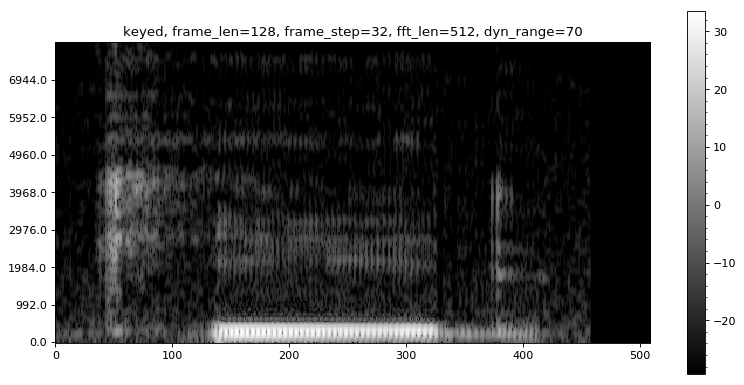

In [3]:
#step 3
#plot spectrogram
#55 for subj1
#52 for sub2
#44 for sub3
sr=16000


#winlen=0.02,
#winstep=0.025,

_LOG_EPS = 1e-6
frame_length= 128 # np.int32(sr*0.005) #window len - 80
frame_step=np.int32(np.round(sr*0.002)) # time step -32 - increase value decreases X-ticks - 0.002 or 0.006
fft_len=512 # increase value increases y ticks 
epochs=2500
fac = fft_len/16

#from griffin lim paper: https://ieeexplore.ieee.org/document/1164317
#if the window length (L) is a multiple of four times the window shift (S)

print(frame_length, frame_step, fft_len)
apply_pre_emp=False
if apply_pre_emp:
    alpha=0.8
    dyn_range=35
else:
    alpha=0.8
    dyn_range=70
apply_reg=False

def get_spectrogram(waveform):
    
    stfts = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    spectrograms = tf.abs(stfts)
    spec_pred_db=10*tf.math.log(spectrograms + _LOG_EPS)
    
    #adjust dynamic range
    mx=tf.math.reduce_max(spec_pred_db)
    spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
    spect = tf.nn.leaky_relu(spec_pred_db, alpha=alpha) 
    return spect
    
def get_mel_spec(waveform):
    
    #The window-size, hop-size and mel dimension are 800, 200, and 80 respectively.
    
    stfts = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    spectrograms = tf.abs(stfts)


    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 10.0, 3000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))
    spect = mel_spectrograms
    print(np.shape(mel_spectrograms))
    return spect


#nfft =1024 # sr/20; # fs/freq_step = 800
#3: coed
#4: keyed
#49 keyed
#48 cooed
#104 keyed

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')

spec_cooed=[]
spec_keyed=[]
spec_cod=[]
for no in range(10):
    sno=0+no
    #print(filelist[sno])
    waveform=Xtrain_aud[sno][:,0]
    #print(np.shape(waveform))
    ## pre emphasis filtering
    if apply_pre_emp:
        pre = np.append(waveform[0], waveform[1:] - 0.97 * waveform[:-1])
    else:
        pre=waveform

    #waveform=waveform[2500:16384,:]
    
    if 1:
        stfts = tf.signal.stft(np.float32(np.transpose(pre)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
        spectrograms = tf.abs(stfts)

        spec_pred_db=10*tf.math.log(spectrograms + _LOG_EPS)
        #print(np.shape(spec_pred_db))
        if 1:
            if no==0:
                avg_spec = tf.abs(spec_pred_db)
            else:
                avg_spec = avg_spec+tf.abs(spec_pred_db)

        if(newlabels[sno]=='keyed'):
            spec_keyed.append(spec_pred_db)
        if(newlabels[sno]=='cooed'):
            spec_cooed.append(spec_pred_db)
        if(newlabels[sno]=='cod'):
            spec_cod.append(spec_pred_db)



        mx=tf.math.reduce_max(spec_pred_db)
        spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
        spec_pred_db = tf.nn.leaky_relu(spec_pred_db, alpha=alpha)
        #spec_pred_db=mel_spectrograms
    else:
        spec_pred_db=get_mel_spec(waveform)
    
    
    
    # for plotting
    if apply_reg==False:
        if sno==6:
            #plt.subplot(5,3,no+1)
            plt.imshow(np.transpose(spec_pred_db[:,:]),origin='lower', cmap='gray')
            locs, labels = plt.yticks()
            val=np.shape(spec_pred_db)[1]
            print(np.shape(spec_pred_db),val)
            plt.yticks(fac*np.arange(8),fac*np.round(0.5*sr/val)*np.arange(8))
            lab=newlabels[sno]
            plt.title(lab[0]+", frame_len="+ str(frame_length)+", frame_step="+str(frame_step)+", fft_len="+str(fft_len)+", dyn_range="+str(dyn_range))
            cbar = plt.colorbar()
            cbar.minorticks_on()

    else:
        avg_spec=avg_spec/120
        plt.imshow(np.transpose(avg_spec[:,:]),origin='lower', cmap='gray')
        locs, labels = plt.yticks()
        val=np.shape(avg_spec)[1]
        plt.yticks(100*np.arange(np.round(val/100)),100*np.round(sr/val)*np.arange(np.round(val/100)))
        plt.title('Average Spectrogram')


        cbar = plt.colorbar()
        cbar.minorticks_on()


In [4]:
#step 4
#spec loss
import keras.backend as K
from librosa import util
from scipy.signal import get_window

_LOG_EPS = 1e-6
samp_rate=sr
nfft = fft_len

#frame_length=1024#np.int32(samp_rate*0.005) #window len
#frame_step=32#np.round(samp_rate*0.002) # time step
#nfft =1024 # sr/20; # fs/freq_step = 800

#Window len: 0.005s
#Max freq=5000Hz
#Time step= 0.002s
#Frequency step=20
#Window shape= gaussian

def tf_cov(ten):
    x = ten#tf.reshape(ten, [-1])
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

class changeAlpha(tf.keras.callbacks.Callback):
    beta=2
    def on_epoch_end(self, epoch, logs={}):
        self.beta = epoch
        #K.set_value(self.beta, K.get_value(epoch))

def mel_mse_loss(frame_step, fft_len):
    def mel_loss(y_true,y_pred):
        #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
        # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1
        mse = MeanSquaredError()
        #256,128
        waveform = y_pred[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        stfts_pred = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)


        #stfts_pred = tf.signal.stft(y_pred[:,:,0], np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
        spectrograms_pred = tf.math.abs(stfts_pred) 

        # Warp the linear scale spectrograms into the mel-scale.
        num_spectrogram_bins = stfts_pred.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 100
        linear_to_mel_weight_matrix_pred = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
          upper_edge_hertz)
        spec_pred_db = tf.tensordot(
          spectrograms_pred, linear_to_mel_weight_matrix_pred, 1)
        spec_pred_db.set_shape(spectrograms_pred.shape[:-1].concatenate(
          linear_to_mel_weight_matrix_pred.shape[-1:]))

        log_mel_spectrograms = tf.math.log(spec_pred_db + 1e-6)
        
        #batchsize x #mfccs x #mel bins
        #(32, 128, 80)
        mfccs_pred = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mel_bins]


        
        waveform = y_true[:,:,0]
        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        stfts_true = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)


        #stfts_true = tf.signal.stft(y_true[:,:,0], np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
        spectrograms_true = tf.math.abs(stfts_true) 

        # Warp the linear scale spectrograms into the mel-scale.
        num_spectrogram_bins = stfts_true.shape[-1]

        linear_to_mel_weight_matrix_true = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
          upper_edge_hertz)
        spec_true_db = tf.tensordot(
          spectrograms_true, linear_to_mel_weight_matrix_true, 1)
        spec_true_db.set_shape(spectrograms_true.shape[:-1].concatenate(
          linear_to_mel_weight_matrix_true.shape[-1:]))
        
        log_mel_spectrograms = tf.math.log(spec_true_db + 1e-6)
        
        mfccs_true = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mel_bins]
        print(np.shape(mfccs_true))
        #debug
        #print(np.shape(spec_pred_db))
        #print(np.shape(spec_true_db))
        #print(np.shape(y_pred),np.shape(y_true))

        #if(np.shape(spec_true_db)[1] == 128):
            #plt.imshow(spec_true_db[1,:,:])
            #plt.imshow(spec_pred_db[1,:,:])
        return mse(mfccs_pred ,mfccs_true)
        #return K.mean(K.sum(K.square(K.abs(spec_pred_db - spec_true_db)), axis=1),axis=-1) 

    return mel_loss

# loss = w1 * low_res + w2 * mid_res + w3 * high_res
def spec_mse_loss(frame_step, fft_len):
    def spec_loss(y_true,y_pred):
        #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
        # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1

        #256,128
        waveform = y_pred[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        spec_pred = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)
        X_mag_pred = tf.math.abs(spec_pred)     
        spec_pred_db = 10*tf.math.log(X_mag_pred + _LOG_EPS)
        if apply_reg:
            spec_reg_term = tf.abs(spec_pred_db)
        mx=tf.math.reduce_max(spec_pred_db)
        spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
        spec_pred_db = tf.nn.leaky_relu(spec_pred_db, alpha=alpha) # set negative values close to zero as we want to match bright regions only


        waveform = y_true[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        spec_true = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)   
        X_mag_true = tf.math.abs(spec_true)
        spec_true_db = 10*tf.math.log(X_mag_true + _LOG_EPS)
        mx=tf.math.reduce_max(spec_true_db)
        spec_true_db= tf.clip_by_value(spec_true_db, mx-dyn_range, mx)
        spec_true_db = tf.nn.leaky_relu(spec_true_db, alpha=alpha)

        #debug
        #print(np.shape(spec_pred_db))
        #print(np.shape(spec_true_db))
        #print(np.shape(y_pred),np.shape(y_true))

        #if(np.shape(spec_true_db)[1] == 128):
            #plt.imshow(spec_true_db[1,:,:])
            #plt.imshow(spec_pred_db[1,:,:])

        #12 481 513
        #1,510,257 <-- with praat params
        if apply_reg:
            avg_spec_db = tf.nn.leaky_relu(avg_spec, alpha=alpha)
            X=tf.reshape(spec_reg_term,[batch_size,np.shape(spec_pred_db)[1]*np.shape(spec_pred_db)[2] ])
            Y=tf.reshape(avg_spec_db,[np.shape(spec_pred_db)[1]*np.shape(spec_pred_db)[2] ])
            #covY=tf_cov(Y)
            #temp=tf.matmul(tf.math.subtract(X,Y), tf.linalg.inv(covY))
            #term = 0.15*tf.matmul(temp, tf.math.subtract(X,Y))
            reg_term = 0.1*K.mean(K.sum(K.square(K.abs(spec_reg_term- avg_spec_db)), axis=1),axis=-1)
        else:
            reg_term=0
        mse = MeanSquaredError()
        
        spec_reshape=tf.expand_dims(spec_pred_db,axis=3)
        grad_image = tf.image.image_gradients(spec_reshape)
        grad_predict=grad_image[1] #along y axis
        print(np.shape(grad_image), np.shape(grad_predict))   
        spec_reshape=tf.expand_dims(spec_true_db,axis=3)
        grad_image = tf.image.image_gradients(spec_reshape)
        grad_true=grad_image[1] #along y axis
 
        #tf.config.experimental_run_functions_eagerly(True)
        #print(mse(spec_pred_db, spec_true_db).numpy(), mse(grad_predict, grad_true).numpy())
        
        #mse of spec is in 100s and mse of grad is in range 3
        #loss_mel = mel_mse_loss(np.int32(np.round(sr*0.002*4)), 128)
        loss_mel = mel_mse_loss(frame_step, fft_len)
        
        return 1*mse(grad_predict, grad_true)+mse(spec_pred_db, spec_true_db) +mel_w*loss_mel(y_true,y_pred)
        #return  K.mean(K.sum(K.square(K.abs(spec_pred_db - spec_true_db)), axis=1),axis=-1) +reg_term
    return spec_loss

def dwindow(window_length, periodic=True, dtype=tf.dtypes.float32):

    #win_len= tf.make_ndarray(window_length.op.get_attr('value'))
    fft_window = util.pad_center(get_window('hamming', frame_length,
                                            fftbins=True), frame_length)

    # Window for discrete differentiation
    # we use a cyclic gradient calculation here to ensure that the edges of
    # the window are handled properly
    d_window = - util.cyclic_gradient(fft_window)
    return d_window

# compute ifgram
def compute_ifgram(y):
    ref_power=1e-6
    
   
    stft_matrix = tf.signal.stft(y,np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
 

    
    diff_stft = tf.math.conj(tf.signal.stft(y, frame_length=np.int32(frame_length), fft_length=nfft, frame_step=np.int32(frame_step),
                     window_fn=dwindow))

    # Compute power normalization. Suppress zeros.
    mag = tf.math.abs(stft_matrix)
    mag **= 1
    phase = tf.math.exp(tf.math.multiply(1.j, tf.cast(tf.math.angle(stft_matrix), dtype=tf.complex128)))


    #ref_power = ref_power(mag**2)
  
    # Pylint does not correctly infer the type here, but it's correct.
    # pylint: disable=maybe-no-member
    freq_angular = np.linspace(0, 2 * np.pi, nfft, endpoint=False)
    freq_angular = freq_angular.reshape((-1, 1))

    #(-phase * diff_stft).imag / mag
    bin_offset = tf.math.imag(-phase * tf.cast(diff_stft, dtype=tf.complex128))/ tf.cast(mag, dtype=tf.float64)
    mask = tf.less(mag, ref_power**0.5)
    bin_offset = tf.multiply(bin_offset, tf.cast(mask, bin_offset.dtype))
    #bin_offset[mag < ref_power**0.5] = 0

    #convert from -pi to pi to 0 to 2*pi
    if_gram = tf.math.add(tf.transpose(freq_angular[:int(nfft//2) + 1]),bin_offset)
    print(np.shape(bin_offset), np.shape(freq_angular), nfft//2 )

    #if_gram *= float(sr) * 0.5 / np.pi
    if_gram = tf.math.multiply(if_gram*float(sr), 1 / (2*np.pi))

    return if_gram, stft_matrix


def ifgram_mse_loss(y_true,y_pred):
    #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
    # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1
    if_gram_pred, stft_matrix_pred = compute_ifgram(y_pred[:,:,0])
    #256,128
  
    if_gram_true, stft_matrix_true = compute_ifgram(y_true[:,:,0])
  
   
    #debug
    #print(np.shape(spec_pred_db))
    #print(np.shape(spec_true_db))
    #print(np.shape(y_pred),np.shape(y_true))
    
    #if(np.shape(spec_true_db)[1] == 128):
        #plt.imshow(spec_true_db[1,:,:])
        #plt.imshow(spec_pred_db[1,:,:])
    return K.mean(K.sum(K.square(K.abs(if_gram_pred - if_gram_true)), axis=1),axis=-1) 




In [12]:
print(frame_length, 1/0.0032)
K.mean(K.sum(K.square(K.abs(spec_pred_db - spec_true_db)), axis=1),axis=-1)
np.shape(spec_pred_db)

80 312.5


TensorShape([1, 170, 257])

In [5]:
#step 5

## DC gans for sound
## create generator
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow import expand_dims
from tensorflow import shape, image
from tensorflow import reshape
def Conv1DTranspose(inputs, filters, kernel_width, stride=4, padding='same',upsample='zeros'):

    if upsample == 'zeros':
        out=Conv2DTranspose(filters,(1, kernel_width),strides=(1, stride),padding='same')(expand_dims(inputs, axis=1))
        return out[:, 0]
    elif upsample == 'nn':
        batch_size = shape(inputs)[0]
        _, w, nch = inputs.get_shape().as_list()
   
        x = inputs
        x = expand_dims(x, axis=1)
        x = image.resize_nearest_neighbor(x, [1, w * stride])
        x = x[:, 0]
        return Conv1d(x,filters,kernel_width,1,padding='same')
    else:
        raise NotImplementedError


learning_rate=0.01
decay_rate=1e-5
gopt = optimizers.Adam(lr=learning_rate, decay=decay_rate)



depth = 128
dim = 32

# get the output of the last layer
   

# input will be features extracted from the video ..channels are probably features from lips, eyebrow and head movement


# input is a vector of 2048 random numbers and convert it to 16x1024 size for convolution

# for every video time frame we want to generate 533.34 (512 nearest power of 2) audio samples
# 1 4 16 64 256 512

#input 58 x 48 or 64 , 80 timepoints x 58 landmark points +1 style

#g_input = Input(shape=[64]) # dense output of classifier
#gen=Dense(dim*depth)(g_input)
if include_style:
    g_input = Input(shape=[frameCount,frameHeight*frameWidth+1])
else:
    g_input = Input(shape=[frameCount,np.shape(landmarks_indices)[0]*2])


gen=Flatten(data_format='channels_first')(g_input)
gen=Dense(dim*depth)(gen)
gen=reshape(gen, [-1, dim, depth])
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/2), kernel_width=25, stride=2)
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)


gen=Conv1DTranspose(gen,filters=int(depth/4), kernel_width=25, padding='same')
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/8), kernel_width=25, padding='same')
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/16), kernel_width=25, padding='same', stride=4)
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

# ...add the following block
#gen=Conv1DTranspose(gen,filters=int(depth/16), kernel_width=25, padding='same', stride=4)
#gen=BatchNormalization(momentum=0.9)(gen)
#gen=Activation('relu')(gen)


# filters==1 needs to be checked
gen=Conv1DTranspose(gen,filters=1, kernel_width=25, padding='same', stride=4)
gen_V=Activation('tanh')(gen)


generator = Model(g_input,gen_V, name='gener')
generator.summary()




Model: "gener"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 58)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 4640)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              19009536  
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 32, 128)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 32, 128)           0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 1, 32, 128)]      0     

In [39]:
print(batch_size)

32


In [6]:
#step 6
#(1349, 16384, 1) (1349, 80, 58)
print(np.shape(Xtrain_aud), np.shape(Xtrain))


#859 starst 1107
#1023 starts 1109
# 1086 starts 1110

#configure these

#use spec loss
spec=1 #use spec loss
mel=0 #use mel loss

cl_learning=1

num=832 #695 for removing 1106 or 832



#get plain style indices
#1 corresponds to clear 
train_idx=np.where(newstyles[0:num]==1)[0]
val_idx = np.where(newstyles[859:859+320]==1)[0]

test_idx1 = np.where(newstyles[860:]==0)
test_idx2 = np.where(newstyles[860:]==1)


if data_augment:
    temp = np.concatenate((Xtrain[0:num],Xtrain_aug[0:num]), axis=0)
    Xtrain_vid_all = np.asarray(np.float32(temp))
    temp_aud = np.concatenate((Xtrain_aud[0:num],Xtrain_aud[0:num]), axis=0)
    Xtrain_aud_all =np.asarray(np.float32(temp_aud))
else:
    Xtrain_aud_all=np.asarray(Xtrain_aud)[train_idx]
    Xtrain_vid_all=np.asarray(np.float32(Xtrain))[train_idx]

print(np.shape(Xtrain_aud_all), np.shape(Xtrain_vid_all))


val_start=859
val_end=val_start+batch_size*10
Xtrain_aud_val=np.asarray(Xtrain_aud)[val_idx]
Xtrain_vid_val=np.asarray(np.float32(Xtrain))[val_idx]#val_start:val_end

outfolder='test_output/'
fname='best_model'

if (opt==1):
    options = '_opt'
elif(opt==2):
    options = '_aligned'
elif(opt==3):
    options = '_aligned_landmarks2'
else:
    options = '_landmark'

if pad_video:
    options = options + '_pad_video'
else:
    options = options + '_interp_video'

if pad_audio:
    options = options + '_pad_audio'
else:
    options = options + '_stretch_audio'

if include_style:
    options = options+'_style'
if region==0:
    options = options+'_jaw'
elif region==1:
    options = options+'_mouthonly'
elif region==2:
    options = options+'_jawmouth'


    
    
options =options+ '_'+str(num) #whether used 1105 subjects or 1106 subjects in training
options =options+ '_framecount_'+str(frameCount)
options =options+ '_melW_'+str(mel_w) +'_'


options = options+'_mouth'
fname=fname+options


#without curriculum learning
C0=[] 
C0.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C0.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


#with curriculum learning
C1=[] 
C1.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C1.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))

C2=[] 
C2.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C2.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


C3=[] 
C3.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C3.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


if cl_learning:
    #low resolution
    #mel_mse_loss or spec_mse_loss

    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history1 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C1)
        generator.load_weights("test_output/"+fname+'_fn_C1.h5')
    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history1_1 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])


    #med resolution
    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002*2)), 512/2), optimizer=gopt,metrics=['mse'])
        history2 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C2)
        generator.load_weights("test_output/"+fname+'_fn_C2.h5')

    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history2_2 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])

    #high resolution
    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002)), 512), optimizer=gopt,metrics=['mse'])
        history3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C3)

    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history3_3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])

else:
    #high resolution
    generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002)), 512), optimizer=gopt,metrics=['mse'])
    history3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                        batch_size=batch_size,
                        epochs=500,
                        validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                        verbose=2,
                        callbacks=C0)


#print('\nhistory dict:', history.history)
#mel loss - 832/832 - 8s - loss: 15.5748 - mae: 0.2019 - val_loss: 10.1861 - val_mae: 0.3856
#spec loss- 832/832 - 7s - loss: 177.5917 - mae: 0.1902 - val_loss: 156.8559 - val_mae: 0.3496

(1349, 16384, 1) (1349, 80, 58)
(372, 16384, 1) (372, 80, 58)
(2,) (None, 128, 65, 1)
(None, None, 100)
Train on 372 samples, validate on 153 samples
Epoch 1/200
(2,) (None, 128, 65, 1)
(None, 128, 100)
(2,) (None, 128, 65, 1)
(None, 128, 100)
(2,) (None, 128, 65, 1)
(None, 128, 100)
372/372 - 11s - loss: 333.0788 - mse: 0.1096 - val_loss: 369.4966 - val_mse: 0.8152
Epoch 2/200
372/372 - 1s - loss: 156.2441 - mse: 0.1365 - val_loss: 217.5177 - val_mse: 0.3554
Epoch 3/200
372/372 - 1s - loss: 143.1598 - mse: 0.1255 - val_loss: 141.0567 - val_mse: 0.1539
Epoch 4/200
372/372 - 1s - loss: 130.2481 - mse: 0.1113 - val_loss: 113.2473 - val_mse: 0.0837
Epoch 5/200
372/372 - 1s - loss: 120.7485 - mse: 0.0898 - val_loss: 107.6155 - val_mse: 0.0614
Epoch 6/200
372/372 - 1s - loss: 121.3206 - mse: 0.0769 - val_loss: 98.6882 - val_mse: 0.0515
Epoch 7/200
372/372 - 1s - loss: 110.7760 - mse: 0.0644 - val_loss: 94.7107 - val_mse: 0.0464
Epoch 8/200
372/372 - 1s - loss: 107.2939 - mse: 0.0530 - val_l

Epoch 86/200
372/372 - 1s - loss: 45.1348 - mse: 0.0394 - val_loss: 59.2414 - val_mse: 0.0414
Epoch 87/200
372/372 - 1s - loss: 43.4622 - mse: 0.0399 - val_loss: 62.1748 - val_mse: 0.0406
Epoch 88/200
372/372 - 1s - loss: 43.7352 - mse: 0.0410 - val_loss: 57.8632 - val_mse: 0.0436
Epoch 89/200
372/372 - 1s - loss: 43.8421 - mse: 0.0413 - val_loss: 60.9838 - val_mse: 0.0416
Epoch 90/200
372/372 - 1s - loss: 43.8554 - mse: 0.0411 - val_loss: 61.4194 - val_mse: 0.0419
Epoch 91/200
372/372 - 1s - loss: 43.5761 - mse: 0.0402 - val_loss: 62.2330 - val_mse: 0.0410
Epoch 92/200
372/372 - 1s - loss: 43.0701 - mse: 0.0405 - val_loss: 63.1535 - val_mse: 0.0420
Epoch 93/200
372/372 - 1s - loss: 42.8787 - mse: 0.0407 - val_loss: 63.4621 - val_mse: 0.0409
Epoch 94/200
372/372 - 1s - loss: 42.9753 - mse: 0.0406 - val_loss: 64.2305 - val_mse: 0.0405
Epoch 95/200
372/372 - 1s - loss: 41.9321 - mse: 0.0404 - val_loss: 61.5163 - val_mse: 0.0413
Epoch 96/200
372/372 - 1s - loss: 42.8791 - mse: 0.0406 - va

Epoch 173/200
372/372 - 1s - loss: 40.1357 - mse: 0.0423 - val_loss: 68.0070 - val_mse: 0.0418
Epoch 174/200
372/372 - 1s - loss: 39.5579 - mse: 0.0414 - val_loss: 64.2164 - val_mse: 0.0421
Epoch 175/200
372/372 - 1s - loss: 39.8580 - mse: 0.0417 - val_loss: 65.6354 - val_mse: 0.0438
Epoch 176/200
372/372 - 1s - loss: 39.8876 - mse: 0.0421 - val_loss: 70.0624 - val_mse: 0.0421
Epoch 177/200
372/372 - 1s - loss: 39.6683 - mse: 0.0411 - val_loss: 68.0274 - val_mse: 0.0417
Epoch 178/200
372/372 - 1s - loss: 39.5788 - mse: 0.0413 - val_loss: 64.7796 - val_mse: 0.0428
Epoch 179/200
372/372 - 1s - loss: 39.0212 - mse: 0.0417 - val_loss: 64.8749 - val_mse: 0.0423
Epoch 180/200
372/372 - 1s - loss: 40.9754 - mse: 0.0415 - val_loss: 65.7469 - val_mse: 0.0433
Epoch 181/200
372/372 - 1s - loss: 40.1711 - mse: 0.0410 - val_loss: 68.4677 - val_mse: 0.0419
Epoch 182/200
372/372 - 1s - loss: 39.4020 - mse: 0.0414 - val_loss: 65.6988 - val_mse: 0.0427
Epoch 183/200
372/372 - 1s - loss: 39.4593 - mse: 

372/372 - 1s - loss: 31.1695 - mse: 0.0449 - val_loss: 52.9013 - val_mse: 0.0456
Epoch 59/200
372/372 - 1s - loss: 31.8707 - mse: 0.0447 - val_loss: 53.0687 - val_mse: 0.0462
Epoch 60/200
372/372 - 1s - loss: 31.4310 - mse: 0.0444 - val_loss: 52.5683 - val_mse: 0.0454
Epoch 61/200
372/372 - 1s - loss: 31.1150 - mse: 0.0443 - val_loss: 53.0982 - val_mse: 0.0454
Epoch 62/200
372/372 - 1s - loss: 31.1634 - mse: 0.0445 - val_loss: 53.6263 - val_mse: 0.0450
Epoch 63/200
372/372 - 1s - loss: 30.9253 - mse: 0.0444 - val_loss: 51.6799 - val_mse: 0.0452
Epoch 64/200
372/372 - 1s - loss: 30.4120 - mse: 0.0447 - val_loss: 51.5366 - val_mse: 0.0466
Epoch 65/200
372/372 - 1s - loss: 30.6000 - mse: 0.0450 - val_loss: 52.7104 - val_mse: 0.0453
Epoch 66/200
372/372 - 1s - loss: 30.6717 - mse: 0.0445 - val_loss: 53.6043 - val_mse: 0.0459
Epoch 67/200
372/372 - 1s - loss: 30.8526 - mse: 0.0445 - val_loss: 56.2636 - val_mse: 0.0444
Epoch 68/200
372/372 - 1s - loss: 30.8423 - mse: 0.0448 - val_loss: 51.72

Epoch 145/200
372/372 - 1s - loss: 35.5136 - mse: 0.0467 - val_loss: 42.4991 - val_mse: 0.0484
Epoch 146/200
372/372 - 1s - loss: 35.5686 - mse: 0.0452 - val_loss: 42.0986 - val_mse: 0.0461
Epoch 147/200
372/372 - 1s - loss: 35.2861 - mse: 0.0461 - val_loss: 42.2677 - val_mse: 0.0475
Epoch 148/200
372/372 - 1s - loss: 34.5665 - mse: 0.0456 - val_loss: 41.9338 - val_mse: 0.0461
Epoch 149/200
372/372 - 1s - loss: 34.1555 - mse: 0.0462 - val_loss: 42.3835 - val_mse: 0.0509
Epoch 150/200
372/372 - 1s - loss: 35.8236 - mse: 0.0454 - val_loss: 43.1082 - val_mse: 0.0465
Epoch 151/200
372/372 - 1s - loss: 34.3059 - mse: 0.0451 - val_loss: 44.1463 - val_mse: 0.0469
Epoch 152/200
372/372 - 1s - loss: 33.3226 - mse: 0.0453 - val_loss: 43.2014 - val_mse: 0.0488
Epoch 153/200
372/372 - 1s - loss: 33.1552 - mse: 0.0454 - val_loss: 43.3827 - val_mse: 0.0477
Epoch 154/200
372/372 - 1s - loss: 33.3434 - mse: 0.0451 - val_loss: 43.9075 - val_mse: 0.0470
Epoch 155/200
372/372 - 1s - loss: 33.1026 - mse: 

Epoch 30/300
372/372 - 1s - loss: 29.9604 - mse: 0.0503 - val_loss: 41.0851 - val_mse: 0.0572
Epoch 31/300
372/372 - 1s - loss: 29.8475 - mse: 0.0490 - val_loss: 43.3126 - val_mse: 0.0500
Epoch 32/300
372/372 - 1s - loss: 30.0402 - mse: 0.0494 - val_loss: 41.0552 - val_mse: 0.0498
Epoch 33/300
372/372 - 1s - loss: 29.7776 - mse: 0.0498 - val_loss: 39.8053 - val_mse: 0.0520
Epoch 34/300
372/372 - 2s - loss: 29.7104 - mse: 0.0500 - val_loss: 39.2777 - val_mse: 0.0523
Epoch 35/300
372/372 - 1s - loss: 29.4421 - mse: 0.0497 - val_loss: 39.6007 - val_mse: 0.0513
Epoch 36/300
372/372 - 1s - loss: 29.1718 - mse: 0.0503 - val_loss: 40.7899 - val_mse: 0.0516
Epoch 37/300
372/372 - 1s - loss: 29.5471 - mse: 0.0501 - val_loss: 40.3870 - val_mse: 0.0536
Epoch 38/300
372/372 - 1s - loss: 29.1810 - mse: 0.0494 - val_loss: 40.4012 - val_mse: 0.0513
Epoch 39/300
372/372 - 1s - loss: 28.8070 - mse: 0.0501 - val_loss: 39.9772 - val_mse: 0.0509
Epoch 40/300
372/372 - 1s - loss: 29.0535 - mse: 0.0499 - va

Epoch 117/300
372/372 - 1s - loss: 27.0513 - mse: 0.0503 - val_loss: 40.5680 - val_mse: 0.0499
Epoch 118/300
372/372 - 1s - loss: 26.8984 - mse: 0.0508 - val_loss: 39.5588 - val_mse: 0.0535
Epoch 119/300
372/372 - 1s - loss: 26.8172 - mse: 0.0510 - val_loss: 41.7902 - val_mse: 0.0503
Epoch 120/300
372/372 - 1s - loss: 27.3624 - mse: 0.0502 - val_loss: 41.5827 - val_mse: 0.0501
Epoch 121/300
372/372 - 1s - loss: 26.9631 - mse: 0.0503 - val_loss: 41.4101 - val_mse: 0.0503
Epoch 122/300
372/372 - 1s - loss: 26.8048 - mse: 0.0508 - val_loss: 41.0067 - val_mse: 0.0508
Epoch 123/300
372/372 - 1s - loss: 26.7100 - mse: 0.0513 - val_loss: 40.5924 - val_mse: 0.0532
Epoch 124/300
372/372 - 1s - loss: 26.5338 - mse: 0.0514 - val_loss: 41.1571 - val_mse: 0.0505
Epoch 125/300
372/372 - 1s - loss: 26.8490 - mse: 0.0508 - val_loss: 41.6333 - val_mse: 0.0503
Epoch 126/300
372/372 - 1s - loss: 26.6636 - mse: 0.0514 - val_loss: 41.6916 - val_mse: 0.0502
Epoch 127/300
372/372 - 1s - loss: 26.7759 - mse: 

Epoch 204/300
372/372 - 1s - loss: 33.1339 - mse: 0.0491 - val_loss: 41.0851 - val_mse: 0.0533
Epoch 205/300
372/372 - 1s - loss: 31.0683 - mse: 0.0492 - val_loss: 39.2969 - val_mse: 0.0548
Epoch 206/300
372/372 - 1s - loss: 29.8447 - mse: 0.0502 - val_loss: 39.1595 - val_mse: 0.0508
Epoch 207/300
372/372 - 1s - loss: 28.8289 - mse: 0.0503 - val_loss: 38.7067 - val_mse: 0.0526
Epoch 208/300
372/372 - 1s - loss: 28.3298 - mse: 0.0512 - val_loss: 38.9526 - val_mse: 0.0513
Epoch 209/300
372/372 - 2s - loss: 27.7664 - mse: 0.0510 - val_loss: 38.0012 - val_mse: 0.0534
Epoch 210/300
372/372 - 1s - loss: 27.3810 - mse: 0.0507 - val_loss: 38.1197 - val_mse: 0.0517
Epoch 211/300
372/372 - 2s - loss: 27.0897 - mse: 0.0516 - val_loss: 37.6630 - val_mse: 0.0531
Epoch 212/300
372/372 - 1s - loss: 26.9914 - mse: 0.0513 - val_loss: 37.8557 - val_mse: 0.0524
Epoch 213/300
372/372 - 1s - loss: 26.9631 - mse: 0.0521 - val_loss: 38.6624 - val_mse: 0.0514
Epoch 214/300
372/372 - 1s - loss: 26.6112 - mse: 

Epoch 291/300
372/372 - 1s - loss: 25.2852 - mse: 0.0525 - val_loss: 38.3197 - val_mse: 0.0513
Epoch 292/300
372/372 - 1s - loss: 25.5721 - mse: 0.0526 - val_loss: 37.8232 - val_mse: 0.0525
Epoch 293/300
372/372 - 1s - loss: 25.4835 - mse: 0.0519 - val_loss: 37.7631 - val_mse: 0.0543
Epoch 294/300
372/372 - 1s - loss: 25.2589 - mse: 0.0525 - val_loss: 37.3011 - val_mse: 0.0539
Epoch 295/300
372/372 - 1s - loss: 25.5444 - mse: 0.0523 - val_loss: 37.8939 - val_mse: 0.0524
Epoch 296/300
372/372 - 1s - loss: 25.0704 - mse: 0.0515 - val_loss: 37.4156 - val_mse: 0.0541
Epoch 297/300
372/372 - 1s - loss: 25.2067 - mse: 0.0530 - val_loss: 37.6097 - val_mse: 0.0540
Epoch 298/300
372/372 - 1s - loss: 25.0132 - mse: 0.0535 - val_loss: 37.4686 - val_mse: 0.0538
Epoch 299/300
372/372 - 1s - loss: 25.0267 - mse: 0.0523 - val_loss: 37.8613 - val_mse: 0.0510
Epoch 300/300
372/372 - 1s - loss: 25.0087 - mse: 0.0525 - val_loss: 37.5664 - val_mse: 0.0527


['keyed'] ['could']
(1, 509, 257) (509, 257)


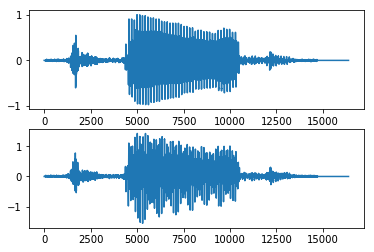

In [17]:
### add generated random phase to ground truth
testid=6
gtid=8
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
  
im= tf.constant([1j], dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)

#compute phase of generated audio
phase_gtid=tf.cast(tf.math.angle(spec_pred),dtype=tf.complex128)
print(np.shape(phase_gtid), np.shape(mag_testid))

#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid[0]))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio.numpy())
scio.wavfile.write('phase_gen_random_audio_'+str(testid)+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())



Text(0, 0.5, 'mean square error')

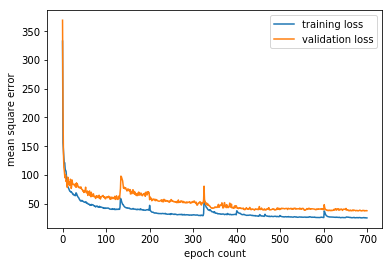

In [7]:
#step 7
#print(dyn_range,np.shape(Xtrain)[0] )
#print(genloss[-1]) #16837.031, 8087.5, 7984.537, 21798.01 21250.178    
if ('history1_1' in locals()) and ('history1' in locals()):
    plt.plot(np.concatenate((history1.history['loss'], history1_1.history['loss'],history2.history['loss'],history2_2.history['loss'], history3.history['loss'], history3_3.history['loss'])), label = 'training loss')
    plt.plot(np.concatenate((history1.history['val_loss'],history1_1.history['val_loss'],  history2.history['val_loss'],history2_2.history['val_loss'], history3.history['val_loss'], history3_3.history['val_loss'])), label = 'validation loss')
elif 'history1' in locals():
    plt.plot(np.concatenate((history1.history['loss'], history2.history['loss'], history3.history['loss'], )), label = 'training loss')
    plt.plot(np.concatenate((history1.history['val_loss'],  history2.history['val_loss'], history3.history['val_loss'], )), label = 'validation loss')    
elif 'history1_1' in locals():
    plt.plot(np.concatenate((history1_1.history['loss'], history2_2.history['loss'], history3_3.history['loss'], )), label = 'training loss')
    plt.plot(np.concatenate((history1_1.history['val_loss'],  history2_2.history['val_loss'], history3_3.history['val_loss'], )), label = 'validation loss')    

    
plt.legend()
plt.xlabel('epoch count')
plt.ylabel('mean square error')

In [10]:
train_idx=np.where(newstyles[0:num]==0)[0]
np.shape(train_idx)

(460,)

In [8]:
#step 8
from librosa.core import griffinlim

rate=16000
#pre_weights = pretrain.get_weights()
#Train: 6 keyed, 4 cooed, 8 could
#Test: 1212,1049,1064,1197 could, 1208,1179,1118,1247 cud, 1020,1182 keyed, 1070,1035,1111,1189 kid, 1039,1075 cooed, 1053,1134 cod
#for testid=860:1348:

## Strings used for different tests
#mel/MFCC only: _diff_1_stretch_mel_mse_fftlen
#mel same params across three curriculums: _diff_1_stretch_mel_same_mse_fftlen
#spec+mel alternating: _diff_1_stretch_spec_mel_mse_fftlen
#spec+mel together: _diff_1_stretch_spec_mel_mse_together_fftlen
#san
#align

X_out=[]
include_phase=1

if 1:
    generator.load_weights("test_output/"+fname+'_fn_C3.h5')
    bm=1 #bestmodel or not
for i in range(1348): #488
    testid=0+i  #860
    string='_diff_1_spec_mse_fftlen' #same refers to mel params being same for different resolutions
    if bm:
        string=string+'_bestmodel_all3_C3_clearOnly'
    if data_augment:
        string=string+'_augment'
    if normalize_video:
        string = string+'_normVideo'
    
    string=string+options
    
    if include_style:
        reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*frameHeight+1]))
    else:
        reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*np.shape(landmarks_indices)[0]]))

        

    gen_wave=generator.predict(reshape_input)

    gt_wave=Xtrain_aud[testid]

    #fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    spec_pred = tf.signal.stft(np.float32(np.transpose(gen_wave[0])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    X_mag_pred = tf.abs(spec_pred)


    spec_pred_db=10*tf.math.log(X_mag_pred + _LOG_EPS)
    mx=tf.math.reduce_max(spec_pred_db)
    spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx, name=None)


    spec_phase_true = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[1])), frame_length, frame_step,fft_length=fft_len, pad_end=False)



    spec_true = tf.signal.stft(np.float32(np.transpose(gt_wave)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    X_mag_true = tf.abs(spec_true)
    spec_true_db=10*tf.math.log(X_mag_true + _LOG_EPS)
    mx=tf.math.reduce_max(spec_true_db)
    spec_true_db= tf.clip_by_value(spec_true_db, mx-dyn_range, mx, name=None)

    if 0:
        plt.subplot(2,2,1)
        plt.imshow(np.transpose(spec_pred_db[0,:,:]),origin='lower', cmap='gray')
        val=np.shape(spec_pred_db)[2]
        plt.yticks(32*np.arange(8),32*np.round(0.5*sr/val)*np.arange(8))

        plt.title('generated '+ 
                  ' pre-empahsis = '+str(apply_pre_emp)+' ' + 
                           'dynamic_range = '+str(dyn_range)+ ' ' +
                           'alpha = '+str(alpha) )
        cbar = plt.colorbar()
        cbar.minorticks_on()

        plt.subplot(2,2,2)
        plt.imshow(np.transpose(spec_true_db[0,:,:]),origin='lower', cmap='gray')
        val=np.shape(spec_true_db)[2]
        plt.yticks(32*np.arange(8),32*np.round(0.5*sr/val)*np.arange(8))
        plt.title('ground truth ' + newlabels[testid][0])
        cbar = plt.colorbar()
        cbar.minorticks_on()
        plt.subplot(2,2,3)
        plt.plot(gen_wave[0])
        plt.title('generated '+ newlabels[testid][0] )

        plt.subplot(2,2,4)
        plt.plot(gt_wave)
        plt.title('ground truth ' + newlabels[testid][0])

        scio.wavfile.write('new_generated_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',wavfile,gen_wave[0])

    #====================== reconstruct audio from spectrogram using GL method
    if 1:#(include_phase==0):
        st=112
        ed=257
        #(1, 509, 257)
        mag_pred = X_mag_pred[0,:,:].numpy()
        #mag_pred[:,st:ed] = X_mag_true[0,:,st:ed] # try to measure the effect of high formants

        print('test_output/new_gl_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav', newlabels[testid])
        wav_audio = griffinlim(np.transpose(mag_pred), hop_length=frame_step, win_length=frame_length)
        #plt.plot(wav_audio)
        scio.wavfile.write('test_output/new_gl_audio_'+string+str(testid)+'_'+newlabels[testid][0]+'_'+str(st)+str(ed)+'.wav',sr,wav_audio)


        print('test_output/new_fixed_combined_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav', newlabels[testid])


        #============= reconstruction from gt phase
        im= tf.constant([1j], dtype=tf.complex128)
        if 1:
            phase=tf.cast(tf.math.angle(spec_phase_true[0]),dtype=tf.complex128)
        else:
            phase=0;
        mag=tf.cast(X_mag_pred[0], dtype=tf.complex128)

        #take the magnitude of generated spectrum and phase from gt spectrum
        combined = tf.math.multiply(mag, tf.math.exp(im*phase))
        combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
        X_out.append(combined_audio)
        #plt.plot(combined_audio)
        #print(np.shape(combined_audio), combined_audio.dtype)
        scio.wavfile.write('test_output/new_fixed_combined_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

#scio.wavfile.write('new_orig_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',rate,gt_wave)


#Audio(data=gen_wave[0].T, rate=sr)
#Audio(data=wav_audio.T, rate=sr)
#Audio(data=combined_audio.numpy(), rate=sr)
#Audio(data=gt_wave.T, rate=sr)

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth0_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth0_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth2_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_ja

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth23_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth24_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth24_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth25_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth25_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_str

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth46_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth47_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth47_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth48_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth48_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_str

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth69_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth70_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth70_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth71_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth71_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_aud

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth92_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth93_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth93_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth94_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth94_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_inte

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth115_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth116_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth116_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth117_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth117_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth138_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth139_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth139_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth140_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth140_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretc

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth161_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth162_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth162_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth163_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth163_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth184_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth185_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth185_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth186_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth186_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretc

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth207_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth208_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth208_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth209_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth209_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth230_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth231_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth231_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth232_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth232_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth253_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth254_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth254_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth255_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth255_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth276_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth277_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth277_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth278_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth278_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth299_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth300_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth300_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth301_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth301_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth322_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth323_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth323_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth324_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth324_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth345_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth346_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth346_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth347_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth347_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretc

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth368_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth369_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth369_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth370_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth370_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth391_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth392_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth392_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth393_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth393_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth414_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth415_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth415_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth416_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth416_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth437_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth438_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth438_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth439_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth439_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth460_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth461_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth461_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth462_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth462_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth483_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth484_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth484_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth485_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth485_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth506_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth507_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth507_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth508_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth508_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth529_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth530_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth530_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth531_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth531_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth552_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth553_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth553_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth554_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth554_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth575_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth576_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth576_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth577_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth577_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth598_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth599_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth599_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth600_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth600_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth621_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth622_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth622_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth623_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth623_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth644_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth645_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth645_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth646_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth646_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth667_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth668_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth668_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth669_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth669_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth690_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth691_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth691_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth692_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth692_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth713_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth714_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth714_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth715_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth715_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth736_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth737_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth737_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth738_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth738_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth759_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth760_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth760_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth761_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth761_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth782_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth783_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth783_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth784_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth784_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_st

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth805_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth806_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth806_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth807_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth807_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth828_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth829_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth829_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth830_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth830_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth851_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth852_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth852_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth853_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth853_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth874_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth875_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth875_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth876_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth876_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth897_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth898_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth898_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth899_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth899_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth920_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth921_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth921_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth922_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth922_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_int

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth943_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth944_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth944_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth945_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth945_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth966_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth967_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth967_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth968_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth968_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth989_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth990_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth990_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth991_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth991_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1012_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1013_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1013_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1014_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1014_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1035_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1036_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1036_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1037_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1037_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1058_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1059_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1059_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1060_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1060_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1081_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1082_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1082_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1083_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1083_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1104_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1105_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1105_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1106_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1106_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1127_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1128_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1128_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1129_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1129_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1150_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1151_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1151_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1152_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1152_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1173_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1174_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1174_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1175_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1175_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1196_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1197_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1197_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1198_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1198_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1219_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1220_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1220_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1221_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1221_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1242_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1243_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1243_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1244_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1244_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1265_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1266_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1266_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1267_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1267_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1288_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1289_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1289_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1290_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1290_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1311_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1312_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1312_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1313_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1313_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1334_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1335_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1335_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1336_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_interp_video_stretch_audio_jawmouth_832_framecount_80_melW_0__mouth1336_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_clearOnly_aligned_in

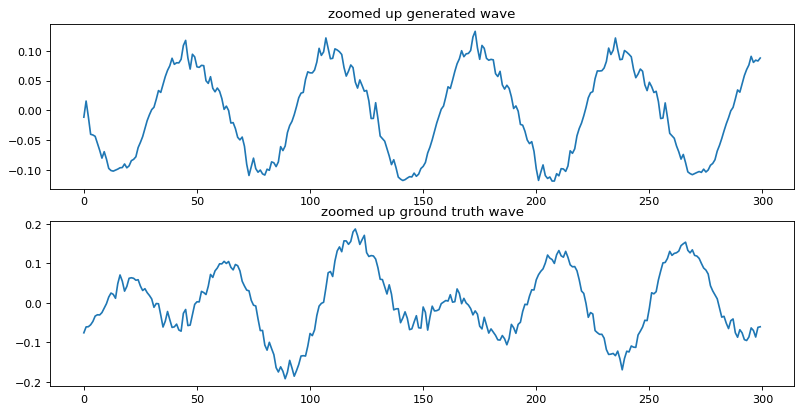

In [16]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(gen_wave[0,4000:4300])
plt.title('zoomed up generated wave')
plt.subplot(2,1,2)
plt.title('zoomed up ground truth wave')
plt.plot(gt_wave[4000:4300])

In [54]:
print(np.shape(gloss))

(200,)


['keyed']


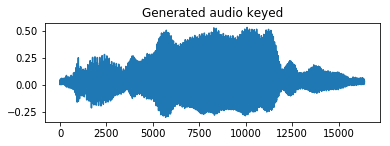

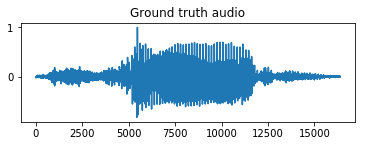

In [75]:
#generate predictions

rate=16000
#pre_weights = pretrain.get_weights()
testid=6
#reshape_input=np.float16(reshape(np.array(Xtrain[testid,:]),[1,frameCount,2*frameHeight]))
reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*frameHeight]))


label= GAN.predict(reshape_input)

print(newlabels[testid])

intermediate_model=GAN.get_layer('gener') #generator
intermediate_prediction2=intermediate_model.predict(reshape_input)


scio.wavfile.write('generated_gan_100_'+newlabels[testid][0]+'.wav',sr,intermediate_prediction2[0])

plt.subplot(2,1,1)
plt.plot(intermediate_prediction2[0])
plt.title('Generated audio ' + newlabels[testid][0])
plt.show()
plt.subplot(2,1,2)
plt.plot(Xtrain_aud[testid])
plt.title('Ground truth audio')
plt.show()
#plt.subplot(3,1,3)
#plt.title('Video Encodings')
#plt.plot(Xtrain[testid])
#plt.show()


(1349, 80, 58) (1349, 80, 58)
(1348, 1)


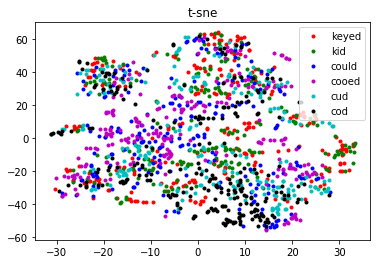

In [4]:
from sklearn.manifold import TSNE
#(107, 45, 64, 64, 2)<-xtrain shape

X=np.nan_to_num(Xtrain)
print(np.shape(Xtrain), np.shape(X))
if 0:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]*np.shape(X)[3]*np.shape(X)[4]))
else:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]))
    #np.where(np.isnan(Xtrain))

labels_emb=newlabels[0:np.shape(X)[0]-1,:]
print(np.shape(labels_emb))
v_embedded = TSNE(n_components=2).fit_transform(X_reshaped)

clrs=['r','g','b','m', 'c', 'k' ]

for i, c in enumerate( ['keyed','kid','could', 'cooed', 'cud', 'cod' ] ):
    q = np.where( labels_emb == c )[0]     
    plt.plot( v_embedded[q,0], v_embedded[q,1],'.', color=clrs[i], label=c )
    
plt.legend()
plt.title('t-sne')
plt.savefig( 'tsne-embedding.png' )


(1349, 80, 58) (800, 80, 58)


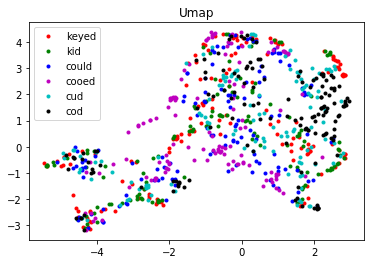

In [31]:
#plot using umap
#!pip install umap-learn
import umap

X=np.nan_to_num(Xtrain[0:800])
print(np.shape(Xtrain), np.shape(X))
if 0:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]*np.shape(X)[3]*np.shape(X)[4]))
else:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]))
    #np.where(np.isnan(Xtrain))

labels_emb=newlabels[0:np.shape(X)[0]-1,:]

embeddings = dict()
embeddings['umap'] = umap.UMAP().fit_transform( X_reshaped ) 

for i, c in enumerate( ['keyed','kid','could', 'cooed', 'cud', 'cod' ] ):
    q = np.where( labels_emb == c )[0]
    plt.plot(embeddings['umap'][q,0], embeddings['umap'][q,1], '.', color=clrs[i],label=c)
plt.title('Umap')    
plt.legend()



In [ ]:
#debug step
np.shape(np.transpose(Xtrain_aud[5,:,:]))
frame_length=512
frame_step=256
#fft_len=512
waveform=Xtrain_aud[3,:,:]
spec_pred = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step, pad_end=True)
X_mag_pred = tf.abs(spec_pred)
spec_pred_db=tf.math.log(X_mag_pred + _LOG_EPS)
np.shape(spec_pred_db)
plt.imshow(spec_pred_db[0,:,:])

# try reconstructing audio from spectrogram stft
inverse_stft = tf.signal.inverse_stft(
    spec_pred, frame_length, frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))

print(np.shape(inverse_stft))
plt.subplot(2,1,1)
plt.plot(inverse_stft[0,:])
plt.subplot(2,1,2)
plt.plot(waveform)

In [ ]:
#ypred=GAN.predict(Xtrain[idx,:,:,:,:])
#print(ypred)
print(GAN.layers[2].name)



sr=16000
rate=sr

_LOG_EPS = 1e-6
frame_length= 128 # np.int32(sr*0.005) #window len - 80
frame_step=np.int32(np.round(sr*0.002)) # time step -32 - increase value decreases x ticks - 0.002 or 0.006
fft_len=512 # increase value increases y ticks 
epochs=2500
fac = fft_len/16

testid=6
gtid=7
print(newlabels[testid], newlabels[gtid])
### reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

### reconstruction from phase of same person different token
testid=6
gtid=8
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())


#reconstruction from phase of another person same token
testid=6
gtid=406
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())




#reconstruction from phase of another person another token
testid=6
gtid=402
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

Audio(data=combined_audio.numpy(), rate=sr)

scio.wavfile.write('phase_orig_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,Xtrain_aud[testid])




In [ ]:
import parselmouth
from parselmouth.praat import call

afile=filelist[7]+'_audio.wav'

sound = parselmouth.Sound(afile)
aud=sound.values.T

wavfile.write('audio_stretched_orig_keyed_praat_audio.wav',sr,aud)

aud, index=effects.trim(np.float32(aud), top_db=freq)
aud=np.append(aud,np.zeros([1024]))
print(np.shape(sound.values), np.shape(aud.T))
sound = parselmouth.Sound(aud.T, sampling_frequency=sr)
#create manipulation object
manipulation = call(sound, "To Manipulation",0.01, 75, 600)

##extract durationtier and add a duration point
duration_tier = call(manipulation, "Extract duration tier")
duration = call(duration_tier, "Add point", sound.duration, shp/(np.shape(aud)[0]*1.0))

#replace the duration tier in the manipulation object
call([duration_tier, manipulation], "Replace duration tier")

#Publish resynthesis
sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")
#sound_octave_up.save("4_b_octave_up.wav", "WAV")

print(afile, sound.duration, sound_octave_up.duration, shp,np.shape(aud)[0],sound_octave_up.sampling_frequency)
np.shape(sound_octave_up.values.T)


aud=sound_octave_up.values.T

wavfile.write('audio_stretched_keyed_praat_audio.wav',sr,aud)

aud=scaler_std.fit_transform(aud)
aud=scaler_max.fit_transform(aud)


wavfile.write('audio_stretched_scaled_keyed_praat_audio.wav',sr,aud)
Audio(data=aud.T, rate=sr)

In [ ]:
#check audio stretch affects the quality of sound.
testid=6
afile=filelist[testid]+'_audio.wav'
sr,aud = wavfile.read(afile)
stretched =effects.time_stretch(np.float32(aud), np.shape(aud)[0]/shp)
reshaped=np.reshape(stretched[0:shp],(shp,1))

scaled1=scaler_std.fit_transform(reshaped)
scaled2=scaler_max.fit_transform(scaled1)

wavfile.write('audio_'+newlabels[testid][0]+'_raw_audio.wav',sr,aud)
wavfile.write('audio_'+newlabels[testid][0]+'_stretched.wav',sr,stretched)
wavfile.write('audio_'+newlabels[testid][0]+'_scaled1.wav',sr,scaled1)
wavfile.write('audio_'+newlabels[testid][0]+'_scaled2.wav',sr,scaled2)


psr,pitchread = wavfile.read('1101_part1_keyed_22012_0_22053_0_mouth_audio_140band.wav')
gsr,glread = wavfile.read('gl_audio_keyed_128257.wav')

shp2=np.shape(glread)[0]
pstretched =effects.time_stretch(np.float32(pitchread), np.shape(pitchread)[0]/shp2)

reshaped=np.reshape(pstretched[0:shp2],(shp2,1))
scaled1=scaler_std.fit_transform(reshaped)
scaled2=scaler_max.fit_transform(scaled1)



print(np.shape(scaled2), np.shape(glread))

pitchadded = glread+1*scaled2[:,0]
wavfile.write('audio_'+newlabels[testid][0]+'_pitch_added_100.wav',sr,pitchadded)

plt.subplot(3,1,1)
plt.plot(glread)

plt.subplot(3,1,2)
plt.plot(0.1*scaled2[:,0])

plt.subplot(3,1,3)
plt.plot(pitchadded)

In [ ]:
#trim audio

#subj=str((1101+1))
#i=1
#afile=join('scratch/avc/lisa_data/'+subj+'/',filelist[i][0:-4]+'_audio.wav')
#sr,aud = wavfile.read(afile)
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')

#for i in range(15):
#    waveform=Xtrain_aud[i]
#    mfccs= feature.mfcc(waveform[:,0], sr=sr,n_mfcc=30)
#    S = feature.melspectrogram(y=waveform[:,0], sr=sr, n_mels=32,fmax=8000)
#    plt.subplot(5,5,i+1)
#    plt.imshow(mfccs)
    
for no in range(15):
    sno=no+0
    waveform, index=effects.trim(Xtrain_aud[sno][:,0], top_db=25)
    #print(np.shape(waveform), np.shape(Xtrain_aud[sno][:,0]))
    waveform=Xtrain_aud[sno][index[0]:index[1]]
    plt.subplot(5,5,no+1)
    plt.plot(waveform)
    plt.title(newlabels[sno])